In [2]:
%load_ext autoreload
%autoreload 2

from bayesflow import benchmarks, diagnostics, trainers
from bayesflow.experimental.free_form_flows import FFFAmortizedPosterior, FFFHParams, FFFNetwork
import numpy as np

2024-01-11 13:03:37.647547: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 13:03:37.694347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 13:03:37.694391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 13:03:37.695715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 13:03:37.702945: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 13:03:37.703464: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Quickstart: Free-form flows for simulation-based inference

Here, we integrate the free-form flow (FFF) loss from Draxler et al. 2023 (arXiv:2310.16624) inthe Bayesflow training routine.
This loss computational efficiently estimates of the gradient of the negative log likelihood (NLL) loss for any network architecture. This overcomes the architectural restrictions of the invertible neural networks used in Bayesflow, which rely on coupling layers of neural ODEs for feasible training. Instead, we can use an encoder and decoder network of arbitrary architecture and even combine summary and inference network into one. The new loss is implemented in a custom amortizer (FFFAmortizer). Similar to the sbi experiments in the original free-form flow paper, we use networks with a combination of fully and resnet layers.

In [11]:
benchmark_name = 'slcp'

training_config = {
    'epochs': 50,
    'iterations': 100,
    'batch_size': 64,
    'validation_sims': 100,
}

n_observations = 100
n_samples = 1000
n_latent = 10000

# hyper parameters for the FFF network
hparams = FFFHParams({
    'activation': 'silu',
    'num_dense_layers': 2,
    'num_resnet_layers': 6,
    'units': 265
}
)

In [12]:
benchmark = benchmarks.Benchmark(benchmark_name, 'posterior')
sample = benchmark.configurator(benchmark.generative_model(2))
sample
print(sample['parameters'].shape)
print(sample['direct_conditions'].shape)

INFO:root:Performing 2 pilot runs with the slcp model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


(2, 5)
(2, 8)


Training with the FFF loss introduces a new hyperparameter $\beta$. The FFF loss consists of two parts $\mathcal{L}_{FFF} = \mathcal{L}_{NLL} + \beta * \mathcal{L}_{recon.}$.

The first term is the approximate NLL loss and the second one a reconstruction loss to ensure invertibility of the encoder and decoder architecture. For more details on the theory, please see the original publication.

In practice, good choices for $\beta$ are in the range of 2 - 1000.

In [21]:
summary_net = lambda x, **kwargs: x

hparams['data_dim'] = 5
hparams['cond_dim'] = 8
hparams['latent_dim'] = 5

fully = FFFNetwork(hparams)
amortizer = FFFAmortizedPosterior(inference_net = fully, beta = 100, surrogate=True, memorize_last_samples=True) # training with the exact negative log likelihood is possible but unfeasible for more complex problems

trainer = trainers.Trainer(
    amortizer=amortizer,
    default_lr=5e-4,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    memory=False,
)

h = trainer.train_online(epochs=training_config['epochs'], iterations_per_epoch=training_config['iterations'], batch_size=training_config['batch_size'], validation_sims=training_config['validation_sims'])

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, nll: 15.870, reconstruction_loss: 458.215, summary_loss: 0.000


Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, nll: 14.390, reconstruction_loss: 239.903, summary_loss: 0.000


Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, nll: 13.748, reconstruction_loss: 152.015, summary_loss: 0.000


Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, nll: 10.340, reconstruction_loss: 18.503, summary_loss: 0.000


Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, nll: 9.928, reconstruction_loss: 9.094, summary_loss: 0.000


Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, nll: 9.917, reconstruction_loss: 5.350, summary_loss: 0.000


Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, nll: 9.824, reconstruction_loss: 4.913, summary_loss: 0.000


Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, nll: 9.781, reconstruction_loss: 3.536, summary_loss: 0.000


Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, nll: 9.803, reconstruction_loss: 4.511, summary_loss: 0.000


Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, nll: 9.769, reconstruction_loss: 4.295, summary_loss: 0.000


Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, nll: 9.760, reconstruction_loss: 2.620, summary_loss: 0.000


Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, nll: 9.726, reconstruction_loss: 3.151, summary_loss: 0.000


Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, nll: 9.722, reconstruction_loss: 3.016, summary_loss: 0.000


Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, nll: 9.771, reconstruction_loss: 2.225, summary_loss: 0.000


Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, nll: 9.686, reconstruction_loss: 1.793, summary_loss: 0.000


Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, nll: 9.706, reconstruction_loss: 2.691, summary_loss: 0.000


Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, nll: 9.745, reconstruction_loss: 3.497, summary_loss: 0.000


Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, nll: 9.654, reconstruction_loss: 1.322, summary_loss: 0.000


Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, nll: 9.639, reconstruction_loss: 2.084, summary_loss: 0.000


Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, nll: 9.655, reconstruction_loss: 1.123, summary_loss: 0.000


Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, nll: 9.657, reconstruction_loss: 1.616, summary_loss: 0.000


Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, nll: 9.620, reconstruction_loss: 0.750, summary_loss: 0.000


Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, nll: 9.618, reconstruction_loss: 1.744, summary_loss: 0.000


Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, nll: 9.575, reconstruction_loss: 0.991, summary_loss: 0.000


Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, nll: 9.575, reconstruction_loss: 0.626, summary_loss: 0.000


Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, nll: 9.581, reconstruction_loss: 1.355, summary_loss: 0.000


Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, nll: 9.574, reconstruction_loss: 0.642, summary_loss: 0.000


Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, nll: 9.562, reconstruction_loss: 0.716, summary_loss: 0.000


Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, nll: 9.547, reconstruction_loss: 0.725, summary_loss: 0.000


Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, nll: 9.537, reconstruction_loss: 0.404, summary_loss: 0.000


Training epoch 31:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, nll: 9.517, reconstruction_loss: 0.542, summary_loss: 0.000


Training epoch 32:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, nll: 9.513, reconstruction_loss: 0.373, summary_loss: 0.000


Training epoch 33:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, nll: 9.505, reconstruction_loss: 0.360, summary_loss: 0.000


Training epoch 34:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, nll: 9.501, reconstruction_loss: 0.286, summary_loss: 0.000


Training epoch 35:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, nll: 9.506, reconstruction_loss: 0.272, summary_loss: 0.000


Training epoch 36:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, nll: 9.493, reconstruction_loss: 0.177, summary_loss: 0.000


Training epoch 37:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, nll: 9.486, reconstruction_loss: 0.234, summary_loss: 0.000


Training epoch 38:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, nll: 9.482, reconstruction_loss: 0.205, summary_loss: 0.000


Training epoch 39:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, nll: 9.470, reconstruction_loss: 0.144, summary_loss: 0.000


Training epoch 40:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, nll: 9.471, reconstruction_loss: 0.133, summary_loss: 0.000


Training epoch 41:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, nll: 9.464, reconstruction_loss: 0.124, summary_loss: 0.000


Training epoch 42:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, nll: 9.457, reconstruction_loss: 0.097, summary_loss: 0.000


Training epoch 43:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, nll: 9.454, reconstruction_loss: 0.097, summary_loss: 0.000


Training epoch 44:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, nll: 9.453, reconstruction_loss: 0.092, summary_loss: 0.000


Training epoch 45:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, nll: 9.450, reconstruction_loss: 0.072, summary_loss: 0.000


Training epoch 46:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, nll: 9.447, reconstruction_loss: 0.064, summary_loss: 0.000


Training epoch 47:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, nll: 9.447, reconstruction_loss: 0.063, summary_loss: 0.000


Training epoch 48:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, nll: 9.447, reconstruction_loss: 0.059, summary_loss: 0.000


Training epoch 49:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, nll: 9.446, reconstruction_loss: 0.056, summary_loss: 0.000


Training epoch 50:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, nll: 9.446, reconstruction_loss: 0.056, summary_loss: 0.000


Importantly, the **training loss gives only an estimate of the gradient of the negative log likelihood** - it is not a meaningful measure to evaluate the training dynamics. So always plot and analyse the validation loss which computes the exact log likelohood.

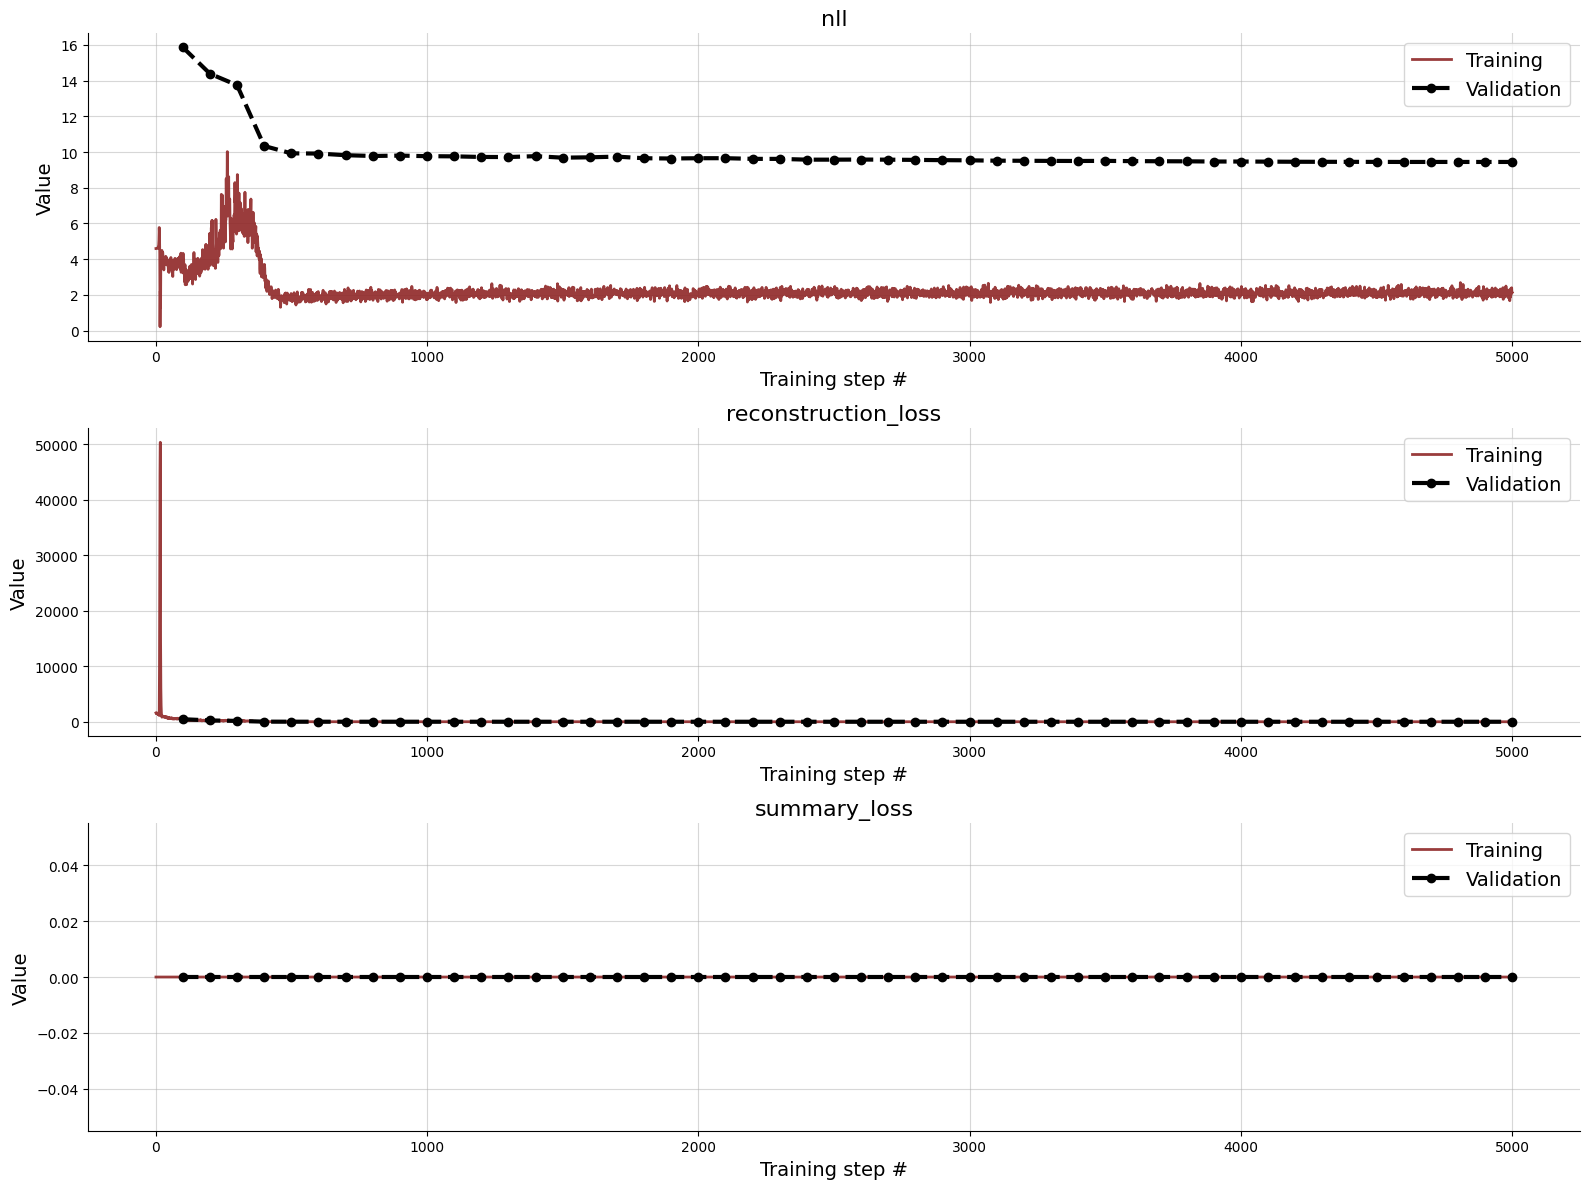

In [22]:
f = diagnostics.plot_losses(h['train_losses'], h['val_losses'], log_scale=False)

/home/l/projects/BayesFlow/bayesflow/diagnostics.py:940: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log" if log_scale else "linear")


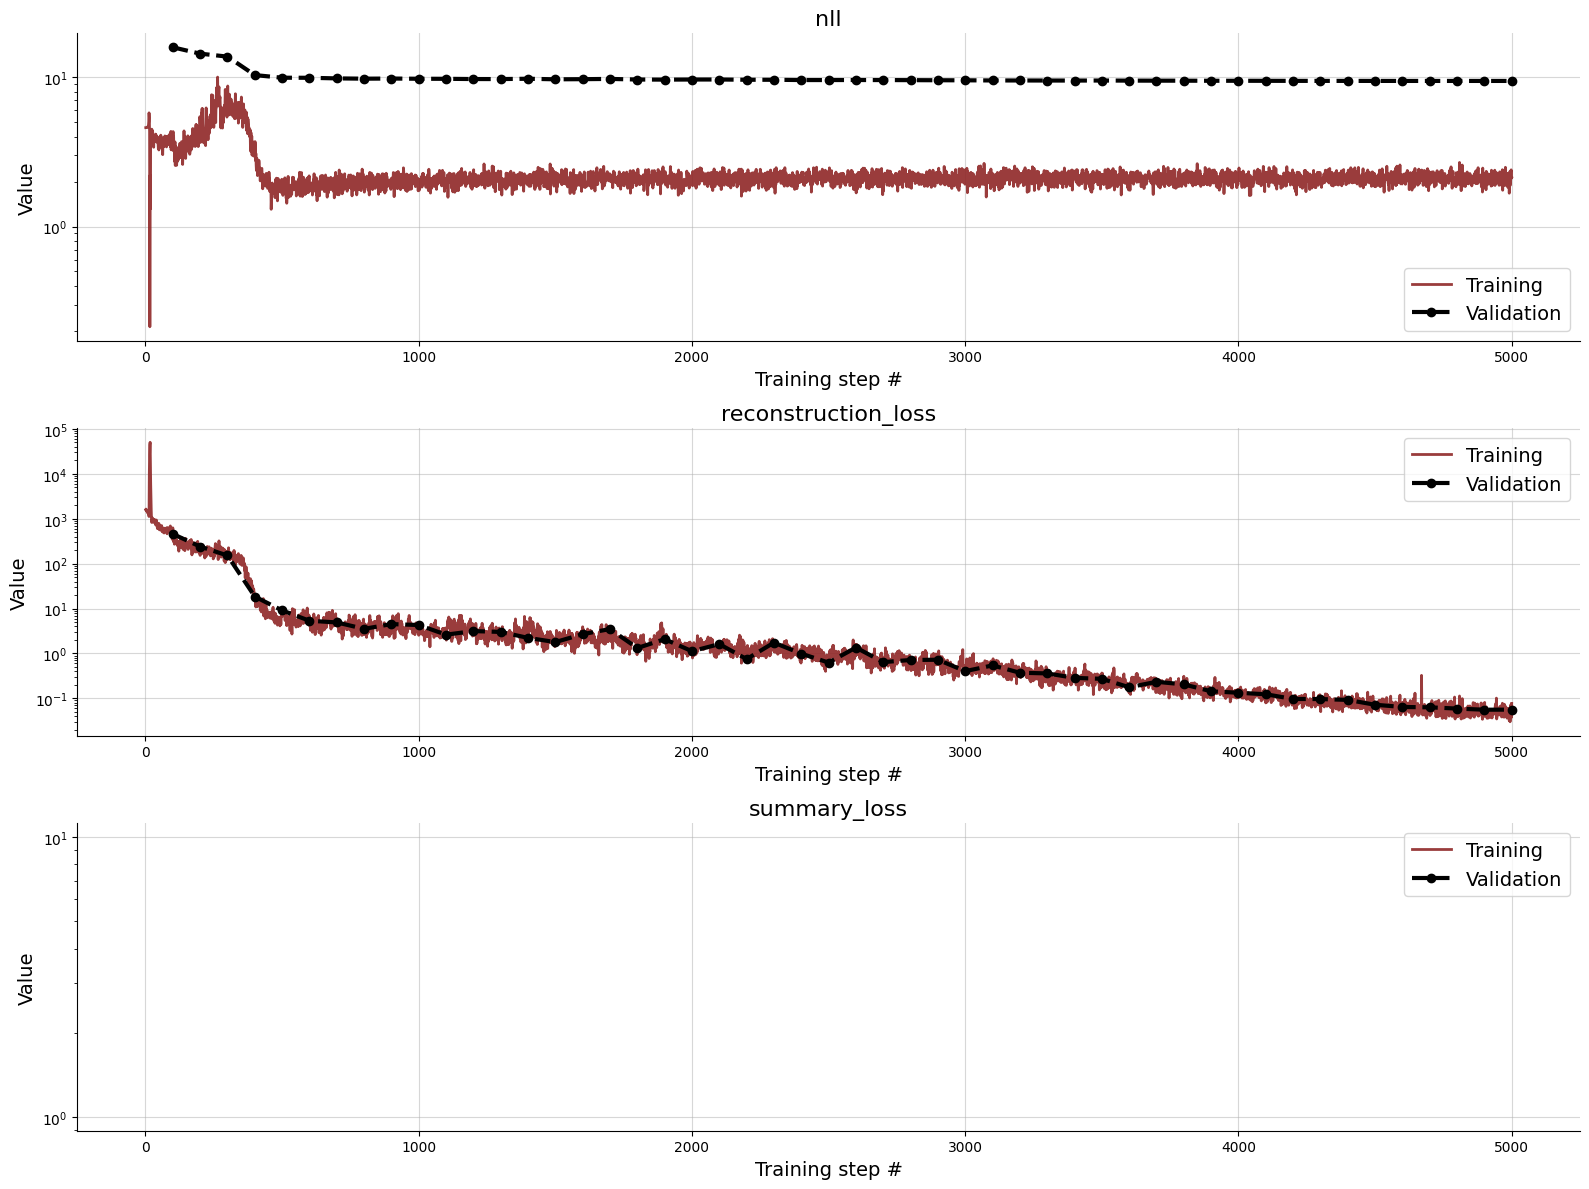

In [23]:
f = diagnostics.plot_losses(h['train_losses'], h['val_losses'], log_scale=True)

In [24]:
amortizer.inference_net.summary()

Model: "fff_network_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            multiple                  3710      
                                                                 
 dense_90 (Dense)            multiple                  70490     
                                                                 
 residual_block_32 (Residua  multiple                  140980    
 lBlock)                                                         
                                                                 
 residual_block_34 (Residua  multiple                  140980    
 lBlock)                                                         
                                                                 
 residual_block_36 (Residua  multiple                  140980    
 lBlock)                                                         
                                                     

## Evaluate on test data

In [32]:
samples = benchmark.configurator(benchmark.generative_model(n_observations))
samples_list = [dict(zip(samples.keys(), values)) for values in zip(*samples.values())]
sample_posterior = amortizer.sample_loop(samples_list, n_samples=n_samples)
samples_l = benchmark.configurator(benchmark.generative_model(n_latent))
sample_latent = amortizer.inference_net(samples_l['parameters'], samples_l['direct_conditions'])

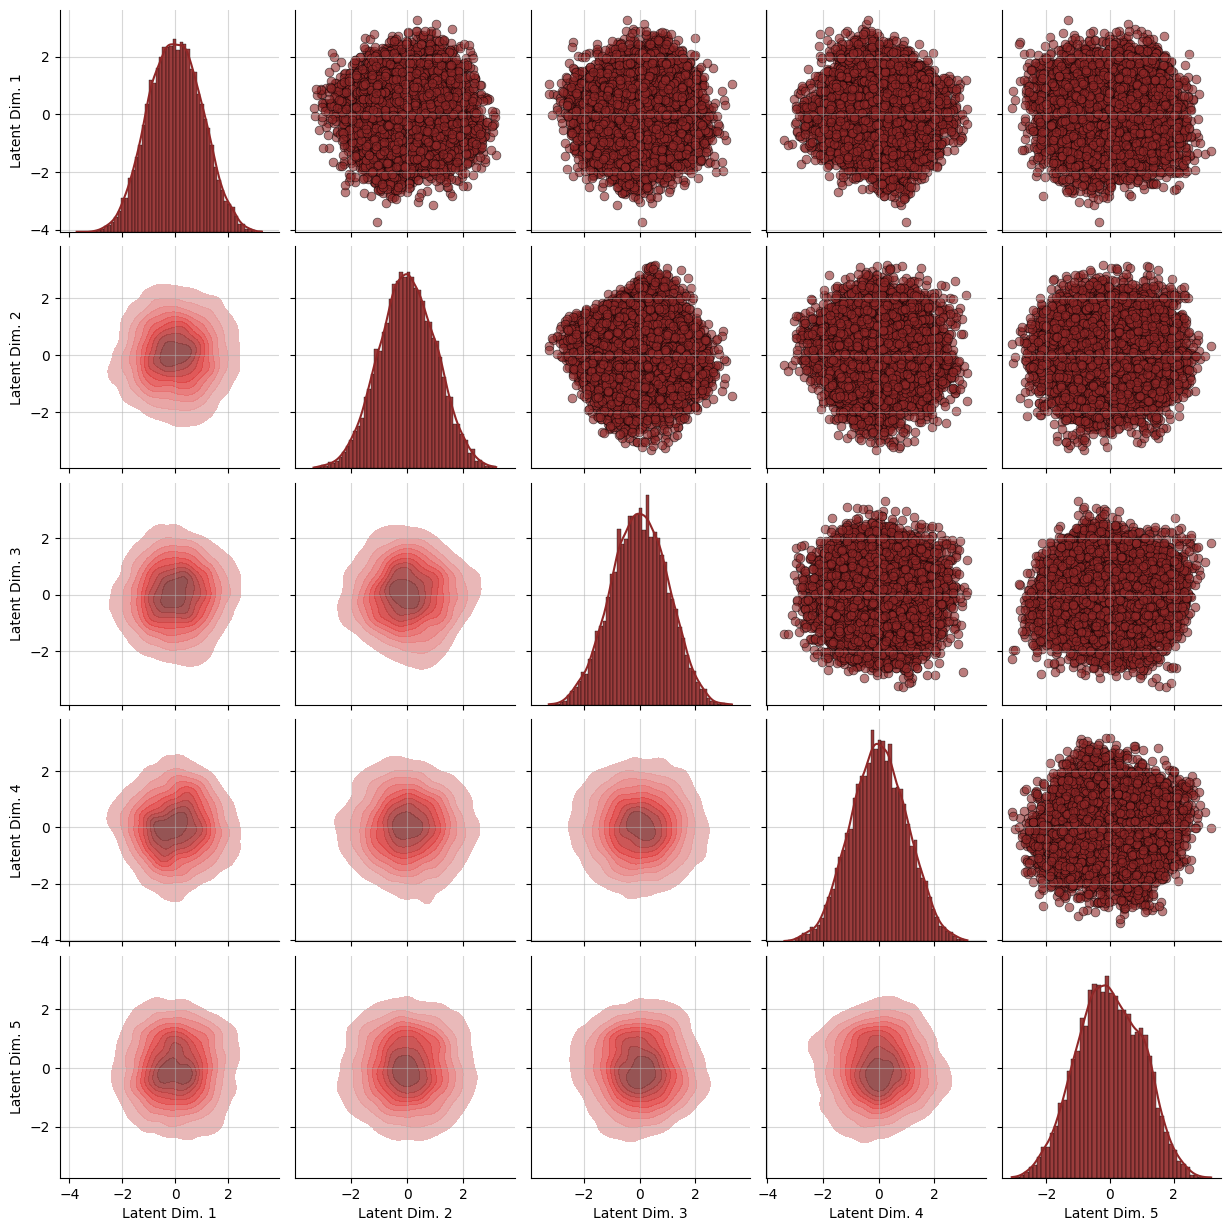

In [27]:
f = diagnostics.plot_latent_space_2d(sample_latent)

In [30]:
print('mean: ', np.mean(sample_latent, axis=0))
print('std: ', np.std(sample_latent, axis=0))

mean:  [-0.004758    0.01819187 -0.00176944  0.01432879 -0.00743513]
std:  [0.9954229 1.0088824 1.0050056 1.0105479 1.006302 ]


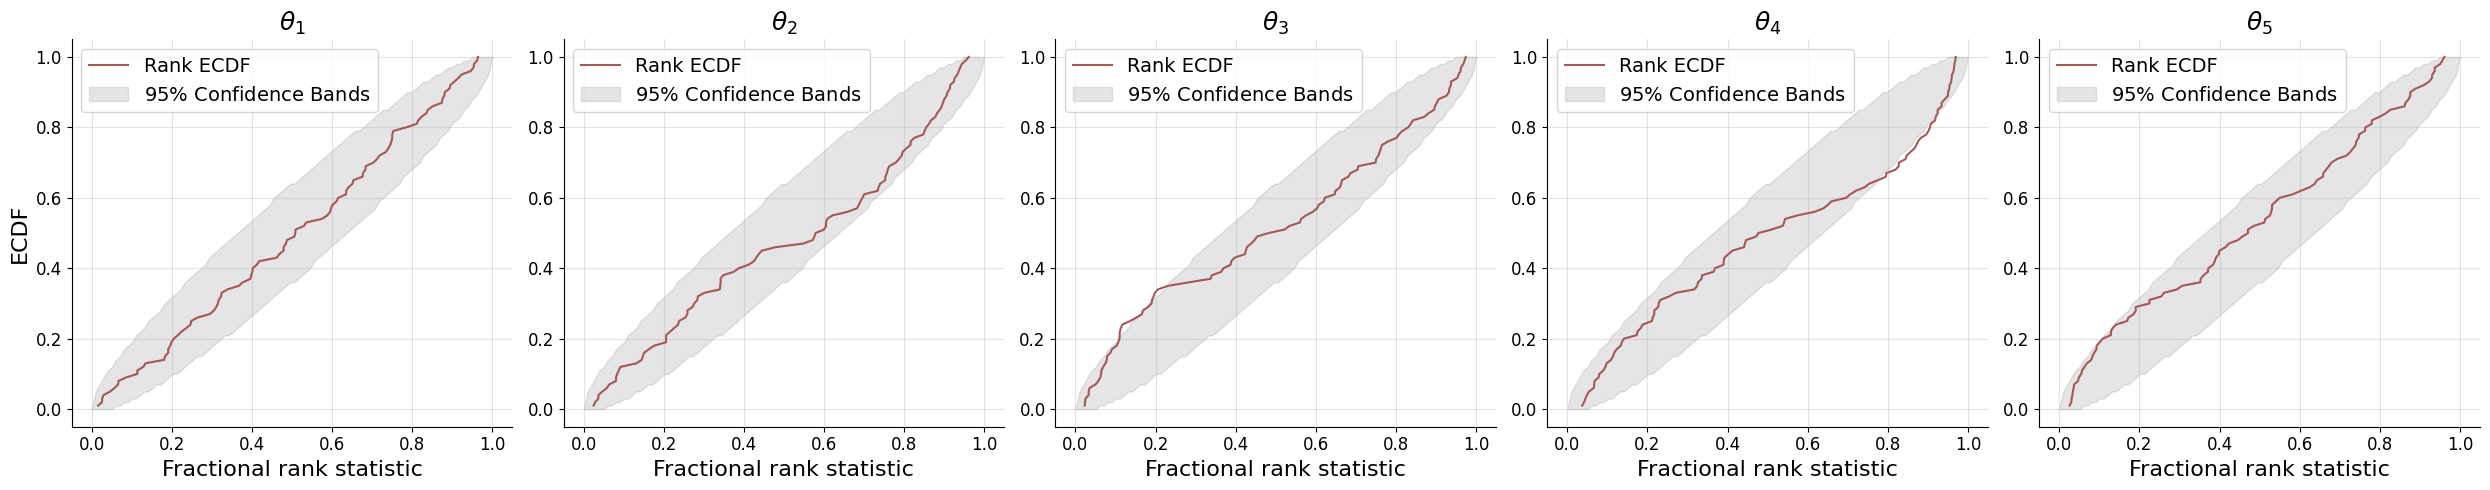

In [31]:
fig = diagnostics.plot_sbc_ecdf(sample_posterior, samples['parameters'])